# Comp1-传统组学

主要适配于传统组学的建模和刻画。典型的应用场景探究rad_score最最终临床诊断的作用。

数据的一般形式为(具体文件,文件夹名可以不同)：
1. `images`文件夹，存放研究对象所有的CT、MRI等数据。
2. `masks`文件夹, 存放手工（Manuelly）勾画的ROI区域。与images文件夹的文件意义对应。
3. `label.txt`文件，每个患者对应的标签，例如肿瘤的良恶性、5年存活状态等。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
2. 组学特征提取，如果第一步检查数据通过，则提取对应数据的特征。
3. 读取标注数据信息。
4. 特征与标注数据拼接。形成数据集。
5. 查看一些统计信息，检查数据时候存在异常点。
6. 正则化，将数据变化到服从 N~(0, 1)。
7. 通过相关系数，例如spearman、person等筛选出特征。
8. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
9. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
10. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
11. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


## 一、数据校验
首先需要检查诊断数据，如果显示`检查通过！`择可以正常运行之后的，否则请根据提示调整数据。

**注意**：这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

### 指定数据

此模块有3个需要自己定义的参数

1. `mydir`: 数据存放的路径。
2. `labelf`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
# 设置数据目录
# mydir = r'你自己数据的路径'
mydir = r'D:\20220421-FANBIN'
# 对应的标签文件
# labelf = r'你自己标注数据的文件地址'
labelf = os.path.join(mydir, 'label.csv')
# 读取标签数据列名
labels = ['label']

### images和masks匹配

这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [2]:
from pathlib import Path
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings, get_image_mask_from_dir

# 生成images和masks对，一对一的关系。也可以自定义替换。
images, masks = get_image_mask_from_dir(mydir, images='images', masks='masks_12')

# 自定义获取images和masks数据的方法，下面的例子为，每个样本一个文件夹，图像是以im.nii结尾，mask是以seg.nii结尾。
# def get_images_mask(mydir):
#     images = []
#     masks = []
#     for root, dirs, files in os.walk(mydir):
#         for f in files:
#             if f.endswith('im.nii'):
#                 images.append(os.path.join(root, f))
#             if f.endswith('seg.nii'):
#                 masks.append(os.path.join(root, f))
#     return images, masks
# images, masks = get_images_mask(mydir)

# diagnose_3d_image_mask_settings(images, masks, verbose=False)
print(f'获取到{len(images)}个样本。')

获取到132个样本。


# 传统组学特征

使用pyradiomics提取传统组学特征，正常这块不需要修改，下面是具体的Onekey封装的接口。

```python
def extract(self, images: Union[str, List[str]], 
            masks: Union[str, List[str]], labels: Union[int, List[int]] = 1, settings=None)
"""
    * images: List结构，待提取的图像列表。
    * masks: List结构，待提取的图像对应的mask，与Images必须一一对应。
    * labels: 提取标注为什么标签的特征。默认为提取label=1的。
    * settings: 其他提取特征的参数。默认为None。

"""
```

```python
def get_label_data_frame(self, label: int = 1, column_names=None, images='images', masks='labels')
"""
    * label: 获取对应label的特征。
    * columns_names: 默认为None，使用程序设定的列名即可。
"""
```
    
```python
def get_image_mask_from_dir(root, images='images', masks='labels')
"""
    * root: 待提取特征的目录。
    * images: root目录中原始数据的文件夹名。
    * masks: root目录中标注数据的文件夹名。
"""
```


In [3]:
import warnings
import pandas as pd
 
warnings.filterwarnings("ignore")

from onekey_algo.custom.components.Radiology import ConventionalRadiomics

if os.path.exists('rad_features1.csv') and os.path.exists('rad_features2.csv'):
    rad_data1 = pd.read_csv('rad_features1.csv', header=0)
    rad_data2 = pd.read_csv('rad_features2.csv', header=0)
else:
    # 如果要自定义一些特征提取方式，可以使用param_file。
    param_file = r'exampleCT.yaml'
#     param_file = None
    radiomics = ConventionalRadiomics(param_file)
    radiomics.extract(images, masks, labels=[1, 2])
    rad_data1 = radiomics.get_label_data_frame(label=1)
    rad_data2 = radiomics.get_label_data_frame(label=2)
    rad_data1.to_csv('rad_features1.csv', header=True, index=False)
    rad_data2.to_csv('rad_features2.csv', header=True, index=False)
print(rad_data1.shape, rad_data2.shape)

(129, 1907) (125, 1907)


In [4]:
print(rad_data1.shape)
rad_data1.head()

(129, 1907)


,ID,exponential_firstorder_10Percentile,exponential_firstorder_90Percentile,exponential_firstorder_Energy,exponential_firstorder_Entropy,exponential_firstorder_InterquartileRange,exponential_firstorder_Kurtosis,exponential_firstorder_Maximum,exponential_firstorder_Mean,exponential_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,00176749.nii.gz,0.962376,2.059142,7.572137e+08,0.159602,0.402076,45.926478,12.348220,1.464470,0.492289,...,0.001429,0.001425,680.648834,0.933675,0.974089,185039.621552,0.001424,8.738796,0.965563,0.037137
1,17026055.nii.gz,1.201357,2.903185,9.395387e+08,0.387598,0.671840,122.104286,64.023255,2.415562,1.387482,...,0.001112,0.001111,848.796685,0.937897,0.975813,406173.333702,0.001111,8.944627,0.967914,0.034260
2,1707170974.nii.gz,1.798579,5.659763,5.075234e+08,0.623116,1.784997,57.784339,34.301035,3.485887,1.398980,...,0.002081,0.002080,450.265979,0.928383,0.971879,142087.266037,0.002080,8.171775,0.962302,0.041764
3,1707296697.nii.gz,0.854276,3.081652,5.149461e+08,0.189317,0.852849,89.532145,29.427824,1.892335,0.969438,...,0.002012,0.002011,489.253465,0.968819,0.988119,178669.889109,0.002011,8.317722,0.984405,0.015591
4,1708204504.nii.gz,1.141922,1.763621,3.730874e+08,0.053645,0.226722,117.436653,10.033452,1.460341,0.257694,...,0.002908,0.002901,309.309456,0.886274,0.954075,85962.902897,0.002899,7.732578,0.938172,0.073021


In [5]:
print(rad_data2.shape)
rad_data2.head()

(125, 1907)


,ID,exponential_firstorder_10Percentile,exponential_firstorder_90Percentile,exponential_firstorder_Energy,exponential_firstorder_Entropy,exponential_firstorder_InterquartileRange,exponential_firstorder_Kurtosis,exponential_firstorder_Maximum,exponential_firstorder_Mean,exponential_firstorder_MeanAbsoluteDeviation,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,00176749.nii.gz,1.377079,14.241176,9.312614e+07,1.666757e+00,5.348359,12.611329,42.427634,6.073401,4.682803,...,0.010902,0.010902,92.000000,1.000000,1.000000,660751.010870,0.010902,6.458345,1.000000,0.000000
1,17026055.nii.gz,1.725509,9.591587,3.745810e+07,1.533410e+00,3.945346,10.422469,27.331282,6.157799,3.303948,...,0.027420,0.027420,37.000000,1.000000,1.000000,391899.513514,0.027420,5.209453,1.000000,0.000000
2,1707170974.nii.gz,4.215457,12.475314,4.368674e+07,1.393456e+00,3.711151,23.515428,45.524873,7.931512,3.578230,...,0.025054,0.025052,34.450000,0.861250,0.943750,76070.500000,0.025051,5.321928,0.930233,0.069375
3,1707296697.nii.gz,1.582838,28.347116,2.249313e+08,2.026334e+00,7.077632,17.799307,119.887899,10.960325,11.417617,...,0.004699,0.004699,211.082949,0.972732,0.989631,294724.512673,0.004699,7.520700,0.986364,0.013634
4,1708204504.nii.gz,1.911046,3.943445,8.043595e+06,-3.203427e-16,1.253919,1.774429,3.943445,2.720681,0.696621,...,0.125535,0.125535,8.000000,1.000000,1.000000,295588.125000,0.125535,3.000000,1.000000,0.000000


## 标注数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [6]:
label_data = pd.read_csv(labelf)
label_data['label'].value_counts()

I      53
V      30
IIA    23
III    11
IV     11
IIB    10
VI      2
Name: label, dtype: int64

In [7]:
label_data = pd.read_csv(labelf)
class_mapping = {'I': 0, "IIA": 1, "IIB": 2, 'III':3, 'IV':4, 'V':5, 'VI':5}
label_data[['label']] = label_data[['label']].applymap(lambda x: class_mapping[x])
label_data[['ID']] = label_data[['ID']].applymap(lambda x: f"{x}.nii.gz")
print(label_data['label'].value_counts())
label_data.head()

0    53
5    32
1    23
3    11
4    11
2    10
Name: label, dtype: int64


,ID,label
0,176749.nii.gz,5
1,17026055.nii.gz,1
2,17098412.nii.gz,5
3,17113727.nii.gz,3
4,17141660.nii.gz,1


## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：需要删掉ID这一列**

In [6]:
# 删掉ID这一列。
combo_data = pd.merge(rad_data1, rad_data2, on=['ID'], how='inner')
combo_data.to_csv('rad_features.csv', index=False)
combined_data = pd.merge(combo_data, label_data, on=['ID'], how='inner')

ids = combo_data['ID']
combined_data = combined_data.drop(['ID'], axis=1)
print(combined_data[labels].value_counts(), combined_data.shape)
combined_data = combined_data.dropna(axis=1)
combined_data.columns

NameError: name 'label_data' is not defined

### 样本可视化

根据特征和label信息，将rad features降维到2维，看不同的label样本在二维空间的分布。

**注意**：由于特征空间维度极高，降维难免会有损失，所以二维的可视化仅供参考。

In [9]:
# from onekey_algo.custom.components.comp1 import analysis_features
# analysis_features(combo_data, combined_data[labels])

## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [10]:
combined_data.describe()

,exponential_firstorder_10Percentile_x,exponential_firstorder_90Percentile_x,exponential_firstorder_Energy_x,exponential_firstorder_Entropy_x,exponential_firstorder_InterquartileRange_x,exponential_firstorder_Kurtosis_x,exponential_firstorder_Maximum_x,exponential_firstorder_Mean_x,exponential_firstorder_MeanAbsoluteDeviation_x,exponential_firstorder_Median_x,...,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_y,wavelet-LLL_glszm_SizeZoneNonUniformity_y,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized_y,wavelet-LLL_glszm_SmallAreaEmphasis_y,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis_y,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_y,wavelet-LLL_glszm_ZoneEntropy_y,wavelet-LLL_glszm_ZonePercentage_y,wavelet-LLL_glszm_ZoneVariance_y,label
count,118.000000,118.000000,1.180000e+02,1.180000e+02,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,...,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.950604,2.227133,3.708483e+08,1.386709e-01,0.549825,88.523433,54.398416,1.717338,0.798913,1.334060,...,0.052246,130.020315,0.984625,0.994019,5.574954e+05,0.052245,5.548339,0.992196,0.008029,2.000000
std,0.229955,0.851562,2.391304e+08,1.433199e-01,0.287837,118.883790,200.984690,0.737732,1.042017,0.390840,...,0.077058,196.270280,0.027285,0.010836,4.143652e+05,0.077058,2.045411,0.013739,0.013872,2.087816
min,0.405646,0.839929,1.404001e+07,-3.203427e-16,0.102229,2.734333,1.357440,0.602335,0.082959,0.554713,...,0.000862,2.000000,0.861250,0.943750,1.364420e+04,0.000862,1.000000,0.930233,0.000000,0.000000
25%,0.811966,1.642350,1.692730e+08,-3.203427e-16,0.367636,13.797959,4.788958,1.285478,0.341888,1.087307,...,0.007511,16.000000,0.972945,0.989644,2.340847e+05,0.007511,4.000000,0.986380,0.000000,0.000000
50%,0.916650,2.017244,3.222503e+08,1.123304e-01,0.490861,41.276009,11.996439,1.556320,0.523589,1.252058,...,0.022757,44.521739,1.000000,1.000000,4.667416e+05,0.022757,5.436837,1.000000,0.000000,1.000000
75%,1.048299,2.529243,5.597016e+08,2.149973e-01,0.653226,121.926789,28.846300,1.904657,0.920579,1.451620,...,0.062721,143.250000,1.000000,1.000000,8.191400e+05,0.062721,7.129818,1.000000,0.014517,4.000000
max,1.902846,5.659763,9.395387e+08,6.415838e-01,1.784997,805.988348,1990.216522,6.691358,8.944321,2.956460,...,0.500006,1131.440241,1.000000,1.000000,2.644827e+06,0.500006,9.594371,1.000000,0.069375,5.000000


## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [11]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=labels)
data.describe()

,exponential_firstorder_10Percentile_x,exponential_firstorder_90Percentile_x,exponential_firstorder_Energy_x,exponential_firstorder_Entropy_x,exponential_firstorder_InterquartileRange_x,exponential_firstorder_Kurtosis_x,exponential_firstorder_Maximum_x,exponential_firstorder_Mean_x,exponential_firstorder_MeanAbsoluteDeviation_x,exponential_firstorder_Median_x,...,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_y,wavelet-LLL_glszm_SizeZoneNonUniformity_y,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized_y,wavelet-LLL_glszm_SmallAreaEmphasis_y,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis_y,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_y,wavelet-LLL_glszm_ZoneEntropy_y,wavelet-LLL_glszm_ZonePercentage_y,wavelet-LLL_glszm_ZoneVariance_y,label
count,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,...,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,118.000000
mean,1.241944e-16,-3.989276e-16,5.551115e-17,-6.115635e-17,-7.903283e-17,4.516161e-17,7.385806e-17,-1.571248e-16,1.129040e-16,-1.524204e-16,...,-6.680155e-17,1.241944e-16,2.454369e-15,1.165287e-14,2.075788e-16,3.857555e-17,5.061864e-16,-5.759400e-15,-4.139815e-17,2.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.087816
min,-2.369847e+00,-1.629012e+00,-1.492107e+00,-9.675618e-01,-1.555035e+00,-7.216215e-01,-2.639056e-01,-1.511394e+00,-6.870848e-01,-1.994030e+00,...,-6.668155e-01,-6.522654e-01,-4.521767e+00,-4.638975e+00,-1.312492e+00,-6.668139e-01,-2.223680e+00,-4.509990e+00,-5.787858e-01,0.000000
25%,-6.028929e-01,-6.867185e-01,-8.429514e-01,-9.675618e-01,-6.329614e-01,-6.285590e-01,-2.468320e-01,-5.853888e-01,-4.385971e-01,-6.313394e-01,...,-5.805299e-01,-5.809352e-01,-4.280649e-01,-4.037229e-01,-7.804967e-01,-5.805282e-01,-7.569821e-01,-4.233375e-01,-5.787858e-01,0.000000
50%,-1.476548e-01,-2.464762e-01,-2.032279e-01,-1.837877e-01,-2.048539e-01,-3.974253e-01,-2.109712e-01,-2.182608e-01,-2.642228e-01,-2.098092e-01,...,-3.826868e-01,-4.356165e-01,5.635011e-01,5.519674e-01,-2.190189e-01,-3.826852e-01,-5.451355e-02,5.679827e-01,-5.787858e-01,1.000000
75%,4.248448e-01,3.547715e-01,7.897504e-01,5.325595e-01,3.592358e-01,2.809749e-01,-1.271346e-01,2.539122e-01,1.167596e-01,3.007885e-01,...,1.359364e-01,6.740544e-02,5.635011e-01,5.519674e-01,6.314348e-01,1.359377e-01,7.731840e-01,5.679827e-01,4.676829e-01,4.000000
max,4.141001e+00,4.030982e+00,2.378160e+00,3.509023e+00,4.291226e+00,6.035010e+00,9.631669e+00,6.742312e+00,7.816964e+00,4.151062e+00,...,5.810725e+00,5.102249e+00,5.635011e-01,5.519674e-01,5.037419e+00,5.810722e+00,1.978102e+00,5.679827e-01,4.422149e+00,5.000000


### 相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

In [12]:
# pearson_corr = data.corr('pearson')
# kendall_corr = data.corr('kendall')
spearman_corr = data.corr('spearman')

### 相关系数可视化

通过修改变量名，可以可视化不同相关系数下的相关矩阵。

**注意**：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import draw_matrix
# plt.figure(figsize=(100.0, 80.0))

# # 选择可视化的相关系数
# draw_matrix(pearson_corr, annot=True, cmap='YlGnBu', cbar=False)
# plt.show()

### 特征筛选 -- 相关系数

根据相关系数，对于相关性比较高的特征（一般文献取corr>0.9），两者保留其一。

```python
def select_feature(corr, threshold: float = 0.9, keep: int = 1, topn=10, verbose=False):
    """
    * corr, 相关系数矩阵。
    * threshold，筛选的相关系数的阈值，大于阈值的两者保留其一（可以根据keep修改，可以是其二...）。默认阈值为0.9
    * keep，可以选择大于相关系数，保留几个，默认只保留一个。
    * topn, 每次去掉多少重复特征。
    * verbose，是否打印日志
    """
```

In [14]:
from onekey_algo.custom.components.comp1 import select_feature
sel_feature = select_feature(spearman_corr, threshold=0.9, topn=128, verbose=False)
sel_feature

['exponential_firstorder_Minimum_x',
 'exponential_firstorder_RobustMeanAbsoluteDeviation_x',
 'exponential_glcm_Correlation_x',
 'exponential_glcm_Idn_x',
 'exponential_glcm_Imc1_x',
 'exponential_gldm_DependenceNonUniformity_x',
 'exponential_gldm_DependenceNonUniformityNormalized_x',
 'exponential_gldm_DependenceVariance_x',
 'exponential_gldm_SmallDependenceLowGrayLevelEmphasis_x',
 'exponential_glrlm_LongRunHighGrayLevelEmphasis_x',
 'exponential_glrlm_LowGrayLevelRunEmphasis_x',
 'exponential_glrlm_RunEntropy_x',
 'exponential_glrlm_RunLengthNonUniformity_x',
 'exponential_glrlm_ShortRunEmphasis_x',
 'exponential_glrlm_ShortRunHighGrayLevelEmphasis_x',
 'exponential_glrlm_ShortRunLowGrayLevelEmphasis_x',
 'exponential_glszm_GrayLevelNonUniformity_x',
 'exponential_glszm_GrayLevelNonUniformityNormalized_x',
 'exponential_glszm_LargeAreaLowGrayLevelEmphasis_x',
 'exponential_glszm_LowGrayLevelZoneEmphasis_x',
 'exponential_glszm_SizeZoneNonUniformity_x',
 'exponential_glszm_SizeZon

### 过滤特征

通过`sel_feature`过滤出筛选出来的特征。

In [15]:
sel_data = data[sel_feature]
print(sel_data.shape)
sel_data.describe()

(118, 687)


,exponential_firstorder_Minimum_x,exponential_firstorder_RobustMeanAbsoluteDeviation_x,exponential_glcm_Correlation_x,exponential_glcm_Idn_x,exponential_glcm_Imc1_x,exponential_gldm_DependenceNonUniformity_x,exponential_gldm_DependenceNonUniformityNormalized_x,exponential_gldm_DependenceVariance_x,exponential_gldm_SmallDependenceLowGrayLevelEmphasis_x,exponential_glrlm_LongRunHighGrayLevelEmphasis_x,...,wavelet-LLL_firstorder_Maximum_y,wavelet-LLL_firstorder_MeanAbsoluteDeviation_y,wavelet-LLL_firstorder_Minimum_y,wavelet-LLL_firstorder_RootMeanSquared_y,wavelet-LLL_firstorder_Skewness_y,wavelet-LLL_glszm_GrayLevelNonUniformity_y,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis_y,wavelet-LLL_glszm_ZoneEntropy_y,wavelet-LLL_glszm_ZoneVariance_y,label
count,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,...,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,1.180000e+02,118.000000
mean,1.392483e-15,-2.079316e-16,-7.150589e-17,-1.022534e-14,1.176084e-16,1.533613e-16,2.022864e-17,2.004047e-16,-1.881734e-16,-2.987253e-17,...,1.173732e-16,-1.851156e-16,1.354848e-16,-2.187516e-16,-1.359553e-16,-5.494663e-16,2.075788e-16,5.061864e-16,-4.139815e-17,2.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.087816
min,-1.907160e+00,-1.496664e+00,-8.846016e-01,-5.024631e+00,-3.600093e+00,-1.208662e+00,-9.180787e-01,-3.037300e+00,-8.100273e-01,-3.439973e-01,...,-1.962852e+00,-1.981124e+00,-1.811343e+00,-2.385263e+00,-3.247732e+00,-5.895330e-01,-1.312492e+00,-2.223680e+00,-5.787858e-01,0.000000
25%,-6.438876e-01,-6.253444e-01,-7.301285e-01,-1.750454e-01,-5.336216e-01,-7.673040e-01,-6.323254e-01,-2.735648e-01,-5.558703e-01,-2.133124e-01,...,-6.494680e-01,-5.985847e-01,-6.970801e-01,-7.462679e-01,-5.623042e-01,-5.895330e-01,-7.804967e-01,-7.569821e-01,-5.787858e-01,0.000000
50%,-1.942942e-01,-2.282116e-01,-5.692529e-01,3.250477e-01,-6.412758e-04,-3.118038e-01,-2.964747e-01,2.601375e-01,-3.085979e-01,-1.419006e-01,...,-1.047342e-02,-2.231883e-02,-1.677126e-01,-8.192179e-02,8.949912e-02,-4.360782e-01,-2.190189e-01,-5.451355e-02,-5.787858e-01,1.000000
75%,2.803618e-01,2.793110e-01,1.575081e+00,7.157491e-01,9.693188e-01,6.506196e-01,2.451804e-01,5.444823e-01,3.891227e-02,-6.078481e-02,...,6.460162e-01,6.665769e-01,4.633869e-01,7.042239e-01,5.999957e-01,2.574543e-01,6.314348e-01,7.731840e-01,4.676829e-01,4.000000
max,4.463930e+00,3.821511e+00,1.575081e+00,7.157491e-01,9.693188e-01,3.620674e+00,5.537303e+00,1.803973e+00,5.481954e+00,9.923226e+00,...,3.191075e+00,3.381994e+00,4.074928e+00,3.237228e+00,2.369671e+00,5.083036e+00,5.037419e+00,1.978102e+00,4.422149e+00,5.000000


## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [16]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 6
y_data = sel_data[labels]
X_data = sel_data.drop(labels, axis=1)
column_names = X_data.columns

X_train, X_test, y_train, y_test = okcomp.comp1.split_dataset(X_data, y_data, test_size=0.3)
print(f"训练集样本数：{X_train.shape}, 验证集样本数：{X_test.shape}")

训练集样本数：(82, 686), 验证集样本数：(36, 686)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

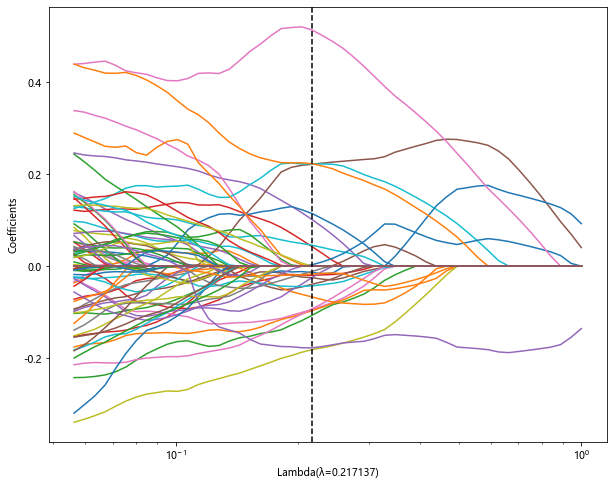

In [17]:
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data, column_names=None, alpha_logmin=-1.25)
plt.savefig(f'img/feature_lasso.svg', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

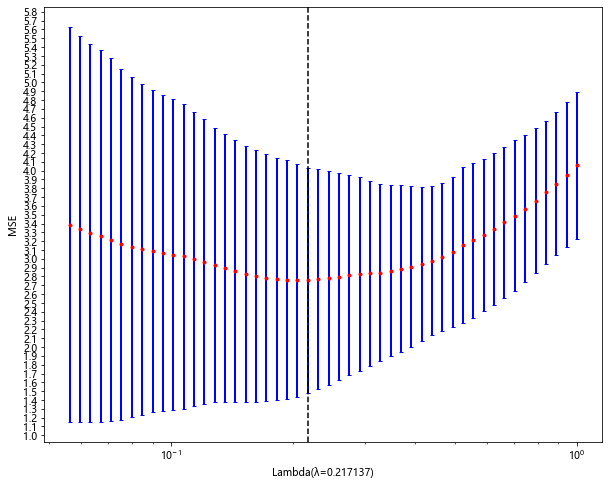

In [18]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50, alpha_logmin=-1.25)
plt.savefig(f'img/feature_mse.svg', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [19]:
from sklearn import linear_model

models = []
for label in labels:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, y_train[label])
    models.append(clf)

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [20]:
COEF_THRESHOLD = 1e-6 # 筛选的特征阈值
scores = []
selected_features = []
for label, model in zip(labels, models):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
print(scores[0])

label = 2.150697091042965 + +0.119719 * exponential_glrlm_ShortRunHighGrayLevelEmphasis_x +0.085145 * exponential_glrlm_ShortRunLowGrayLevelEmphasis_x +0.097887 * exponential_glszm_LowGrayLevelZoneEmphasis_x +0.013850 * lbp-3D-m2_glcm_ClusterShade_x -0.148775 * log-sigma-5-0-mm-3D_firstorder_Kurtosis_x -0.034254 * log-sigma-5-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_x +0.114048 * wavelet-HHL_firstorder_Median_x -0.046075 * wavelet-HLH_firstorder_Skewness_x -0.070277 * exponential_glszm_LowGrayLevelZoneEmphasis_y +0.089609 * exponential_glszm_ZoneEntropy_y +0.093601 * lbp-3D-m2_gldm_DependenceVariance_y +0.365511 * lbp-3D-m2_gldm_LargeDependenceLowGrayLevelEmphasis_y -0.316572 * log-sigma-2-0-mm-3D_firstorder_Skewness_y +0.079257 * log-sigma-3-0-mm-3D_firstorder_Kurtosis_y +0.322044 * square_firstorder_Range_y +0.249808 * square_firstorder_RootMeanSquared_y +0.177187 * square_glszm_LargeAreaHighGrayLevelEmphasis_y +0.302599 * wavelet-HHH_firstorder_Maximum_y


### 特征权重

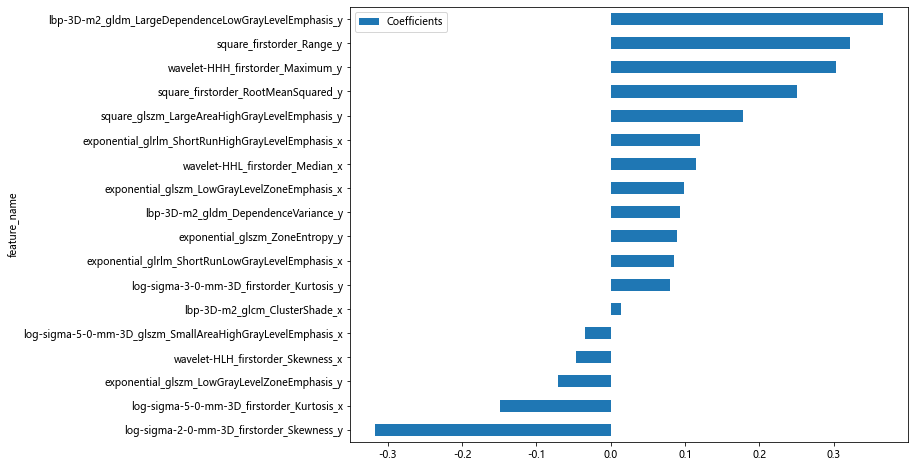

In [21]:
feat_coef = sorted(feat_coef, key=lambda x: x[1])
feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')
plt.savefig(f'img/feature_weights.svg', bbox_inches = 'tight')

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [22]:
X_data = X_data[selected_features[0]]
X_data.columns

Index(['exponential_glrlm_ShortRunHighGrayLevelEmphasis_x',
       'exponential_glrlm_ShortRunLowGrayLevelEmphasis_x',
       'exponential_glszm_LowGrayLevelZoneEmphasis_x',
       'lbp-3D-m2_glcm_ClusterShade_x',
       'log-sigma-5-0-mm-3D_firstorder_Kurtosis_x',
       'log-sigma-5-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_x',
       'wavelet-HHL_firstorder_Median_x', 'wavelet-HLH_firstorder_Skewness_x',
       'exponential_glszm_LowGrayLevelZoneEmphasis_y',
       'exponential_glszm_ZoneEntropy_y',
       'lbp-3D-m2_gldm_DependenceVariance_y',
       'lbp-3D-m2_gldm_LargeDependenceLowGrayLevelEmphasis_y',
       'log-sigma-2-0-mm-3D_firstorder_Skewness_y',
       'log-sigma-3-0-mm-3D_firstorder_Kurtosis_y',
       'square_firstorder_Range_y', 'square_firstorder_RootMeanSquared_y',
       'square_glszm_LargeAreaHighGrayLevelEmphasis_y',
       'wavelet-HHH_firstorder_Maximum_y'],
      dtype='object')

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [23]:
model_names = ['SVM', 'KNN', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'XGBoost', 'LightGBM']
models = okcomp.comp1.create_clf_model(model_names)
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。

这里的数据并没有使用前面`Lasso`筛选出来的特征进行训练，理论来说，特征筛选仅对线性模型有一定作用，例如`SVM`、`LR`，但是对树模型没什么作用，例如`DecisionTree`、`Random`这些。所以默认不筛选。

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

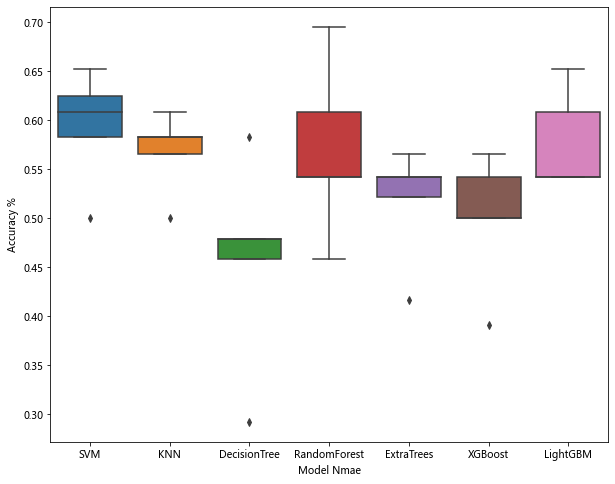

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.2, metric_fn=accuracy_score, n_trails=5, random_state=0, cv=True)
_, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.boxplot(data=cv_results)
plt.ylabel('Accuracy %')
plt.xlabel('Model Nmae')
plt.savefig(f'img/model_cv.svg', bbox_inches = 'tight')

In [36]:
y_test_sel.value_counts()

label
0        9
5        6
1        3
3        2
4        2
2        1
dtype: int64

In [37]:
# from onekey_algo.custom.components.comp1 import smote_resample

# X_train_smote, y_train_smote = smote_resample(X_train_sel, y_train_sel)
# print(f"采用前：{X_train_sel.shape};采样后：{X_train_smote.shape}")

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [38]:
targets = []
for l in labels:
    new_models = list(okcomp.comp1.create_clf_model(model_names).values())
    for m in new_models:
        m.fit(X_train_sel, y_train_sel[l])
        y_pred = m.predict(X_test_sel)
    targets.append(new_models)

## 预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import calc_sens_spec

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        metric.append((mname, accuracy_score(y_train_sel[label], train_pred), f"{label}-train"))
                 
        # 计算验证集指标
        metric.append((mname, accuracy_score(y_test_sel[label], test_pred), f"{label}-test"))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'Task'])
metric

,model_name,Accuracy,Task
0,SVM,0.715789,label-train
1,SVM,0.608696,label-test
2,KNN,0.705263,label-train
3,KNN,0.565217,label-test
4,DecisionTree,1.000000,label-train
5,DecisionTree,0.478261,label-test
6,RandomForest,0.989474,label-train
7,RandomForest,0.695652,label-test
8,ExtraTrees,1.000000,label-train
9,ExtraTrees,0.565217,label-test


In [40]:
print(pred_scores[0][-1][-1].shape)

(23, 6)


### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

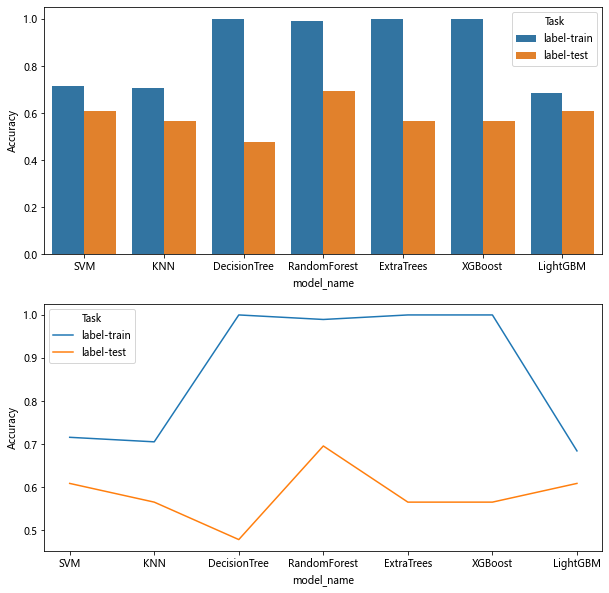

In [41]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/feature_acc.svg', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

In [42]:
# from sklearn.metrics import roc_curve, auc, accuracy_score

# def convet2onehot(data, n_classes):
#     data = np.reshape(data, -1)
#     onehot_encoder = []
#     for d in data:
#         onehot = [0] * n_classes
#         onehot[d] = 1
#         onehot_encoder.append(onehot)
#     return np.array(onehot_encoder)

# def draw_roc_per_class(y_test, y_score, n_classes, title='ROC per Class', include_spec_class:bool=True):
#     enc = OneHotEncoder(handle_unknown='ignore')
#     y_test_binary = convet2onehot(y_test, n_classes=n_classes)
#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     if include_spec_class:
#         for i in range(n_classes):
#             fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_score[:, i])
#             roc_auc[i] = auc(fpr[i], tpr[i])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), y_score.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     lw = 2
#     plt.plot(
#         fpr["micro"],
#         tpr["micro"],
#         label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#         color="deeppink",
#         linestyle=":",
#         linewidth=4,
#     )

#     plt.plot([0, 1], [0, 1], "k--", lw=lw)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("1 - Specificity")
#     plt.ylabel("Sensitivity")
#     plt.title(title)
#     plt.legend(loc="lower right")


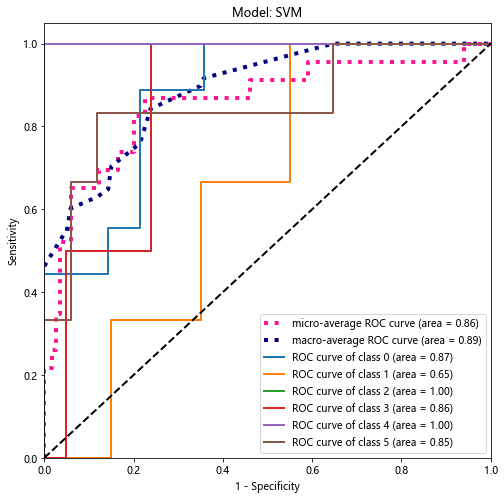

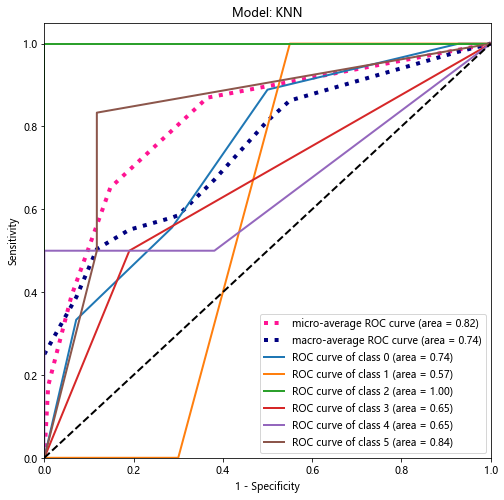

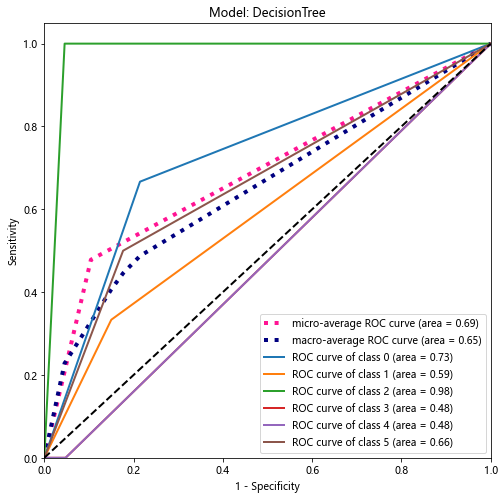

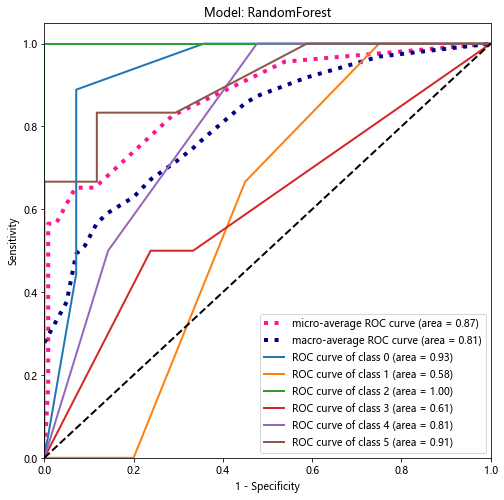

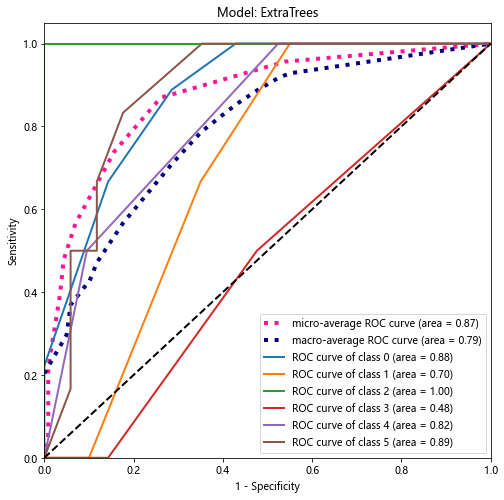

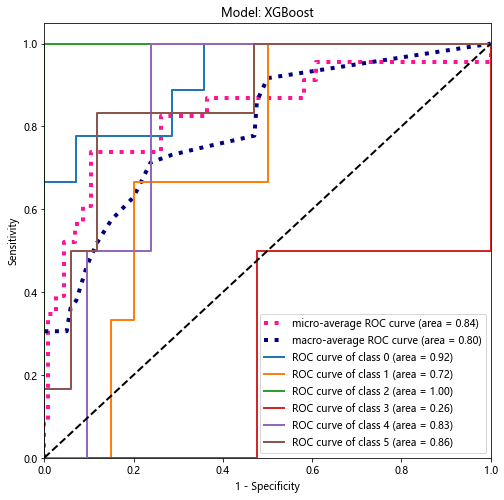

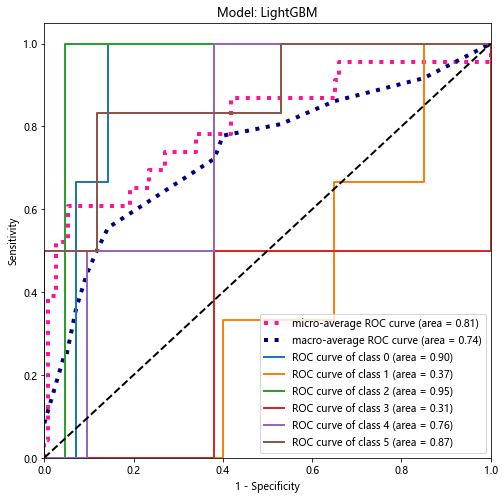

In [43]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc_per_class(np.array(y_test_sel[label]), pred_score[sel_model_idx][-1], n_classes=6, 
                                            title=f"Model: {sm}", include_spec_class=True)
            plt.savefig(f'img/model_{sm}_auc.svg', bbox_inches = 'tight')

### 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

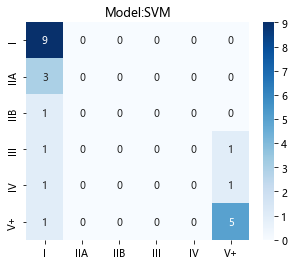

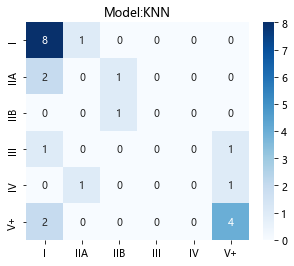

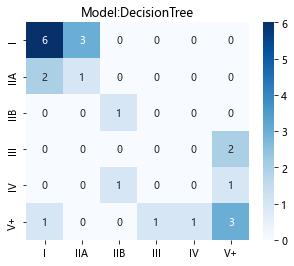

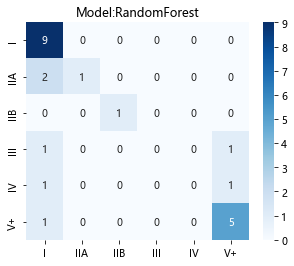

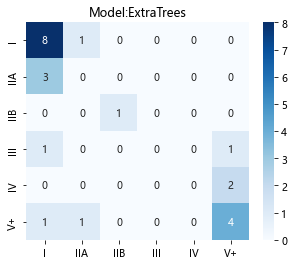

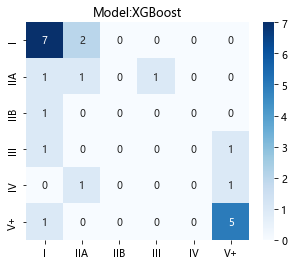

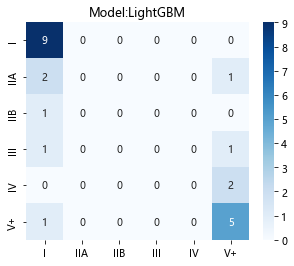

In [45]:
# 设置绘制参数
sel_model = model_names
c_matrix = {}
class_mapping = {'I': 0, "IIA": 1, "IIB": 2, 'III':3, 'IV':4, 'V+':5}
for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][-1], y_test_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={v: k for k, v in class_mapping.items()}, num_classes=6)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.0f')
            plt.savefig(f'img/model_{sm}_cm.svg', bbox_inches = 'tight')

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [34]:
import numpy as np

sel_model = model_names

for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(ids.loc[list(X_train_sel.index)]), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(ids.loc[list(X_test_sel.index)]), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'./results/{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'./results/{sm}_test.csv', index=False)

PermissionError: [Errno 13] Permission denied: './results/SVM_train.csv'